# Projet : Série Chronologique

### <i>Par Vahia Rabarijoana et Kévin Jousselin</i>

#### Master DataScience - Université d'Angers : <a href='https://math.univ-angers.fr/master-data-science/'>Master DS</a>

Nous avons choisis d'étudier le nombre de vidéos postées sur Youtube France entre 03/08/2022 et 01/12/2022. Pour cela, nous avons récupérer l'ensemble des données disponibles à ce sujet sur <a href=https://www.kaggle.com/>Kaggle</a> : le fichier <u>'FR_youtube_trending_data.csv' (250 Mo)</u> issu du dataset <a href=https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset>'YouTube Trending Video Dataset (updated daily)'</a>.

Puis nous avons traité ces données afin de compter le nombre de publications par semaines (voir le Jupyter Notebook '<u>Extraction_donnees.ipynb</u>'). Nos données extraites ont été enregistrés dans le fichier <u>'data/export_nb_par_semaine.csv'</u>.

Nous allons maintenant tenter d'utiliser les méthodes ARIMA, SARIMA afin de modéliser le nombre de publications par semaine.

Voici le plan d'étude :

I - Extraction et observation des données

II - Recherche de différents modèles

III - Choix du "meilleur" modèle

IV - Prédiction avec le meilleur modèle

# I - Extraction et observation des données

#### Importation des modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')   # Supprimer les avertissements liés aux tests Auto_Arima
warnings.simplefilter("ignore")            # supprimer l'avertissement lié au test KPSS 'The actual p-value is greater than the p-value returned.'
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)     # Supprimer l'avertissement lié au temps de convergence

# On importe quelques outils pour les SARIMA, ACF/PACF, tests usuels, ...
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller

#### Importation des données

In [2]:
# dossier = '/users/2023/ds2/118003905/M2_serie_chrono/'
dossier = 'data/'
fichier = 'export_nb_par_semaine.csv'
#fichier = 'export_fr_par_jour.csv'

# On va travailler sur le jeu de données suivant :
Data = pd.read_csv(dossier+fichier)

# On enlève les premières dernières semaines qui représentent des semaines non entières.
Data = Data.iloc[2:-2]

# On renome les colonnes :
Data.columns = ['week', 'nb_vues']

# Séparons les dates, des valeurs :
Data_dates = Data['week']
Data_values = Data['nb_vues']

# 5 premières données :
print(Data.head(5))
n = len(Data_values)
print(n)

         week  nb_vues
2  2020-08-15     1395
3  2020-08-22     1428
4  2020-08-29      473
5  2020-09-01     1459
6  2020-09-08     1409
135


#### Testons immédiatement la stationnarité :

In [4]:
TestA = adfuller(Data_values) # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(Data_values) # Test KPSS :       H0 Stationnaire
print("KPSS p-val : ", TestK[1])


ADF p-val :  2.283068542607219e-05
KPSS p-val :  0.1


C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Les tests semblent indiquer une stationnarité, mais cela reste douteux (p-value KPSS proche de 10%), observons les données :

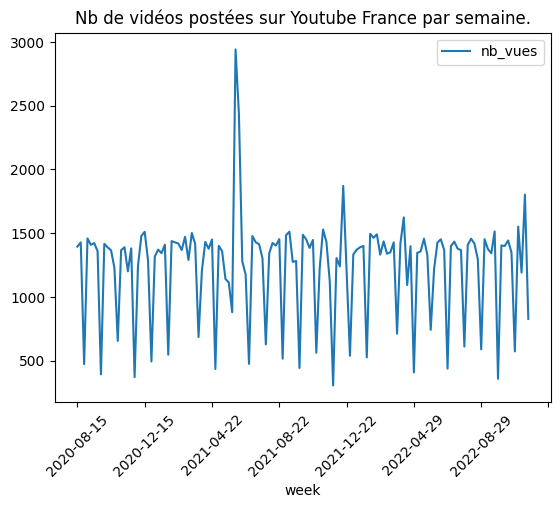

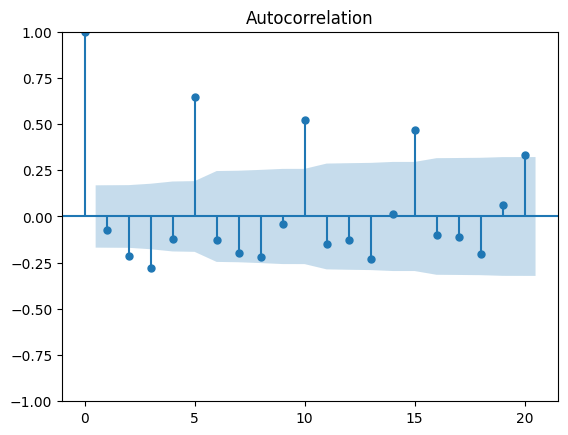

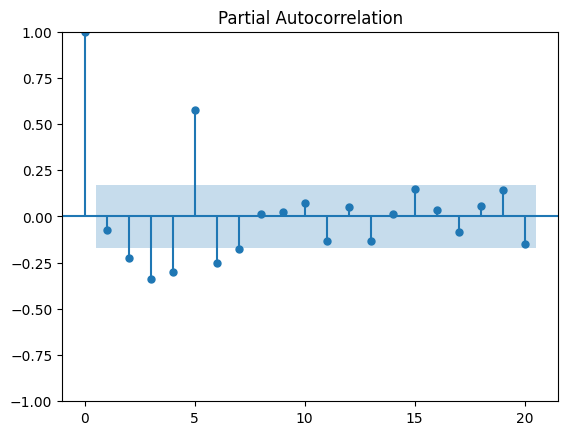

In [6]:
Data.plot(title = 'Nb de vidéos postées sur Youtube France par semaine.', x='week')
plt.xticks(rotation= 45)
plot_acf(Data_values, lags=20, alpha=0.05)
plot_pacf(Data_values, lags=20, alpha=0.05)
plt.show()

On observe clairement une périodicité de période 5, la série n'est pas stationnaire.

Appliquons une décomposition pour extraire les tendances linéaires et périodiques :

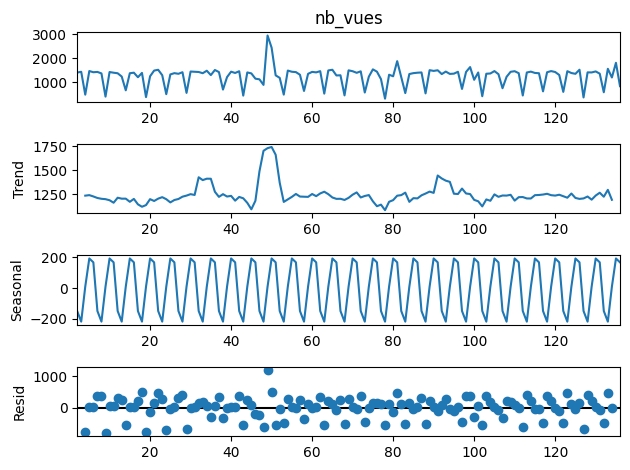

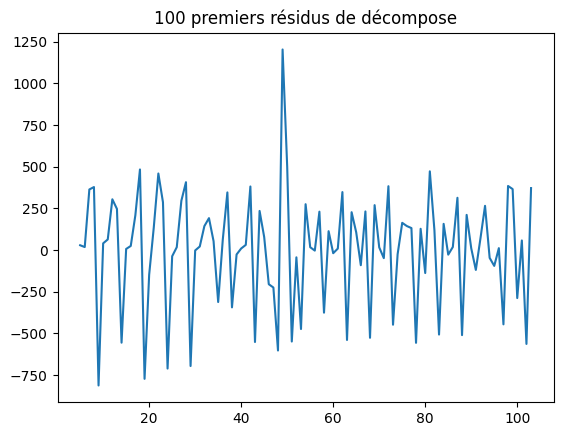

ADF p-val :  1.291442472591275e-07
KPSS p-val :  0.09680710797781689


In [7]:
# Décomposition 
Decomp = sm.tsa.seasonal_decompose(Data_values, model='additive', period = 5)
Decomp.plot()
plt.show()

# Regardons les rédidus
residus = Decomp.resid.dropna()
residus[1:100].plot()
plt.title('100 premiers résidus de décompose')
plt.show()

# Testons la stationnarité après désaisonnalisation (sur les résidus)
TestA = adfuller(residus)   # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(residus)       # Test KPSS :   H0 Stationnaire
print("KPSS p-val : ", TestK[1])


Avant de modéliser les données, choississons une <b>transformation de Box-Cox</b> dans le but de normaliser les données, et de mieux appréhender la variabilité des données :

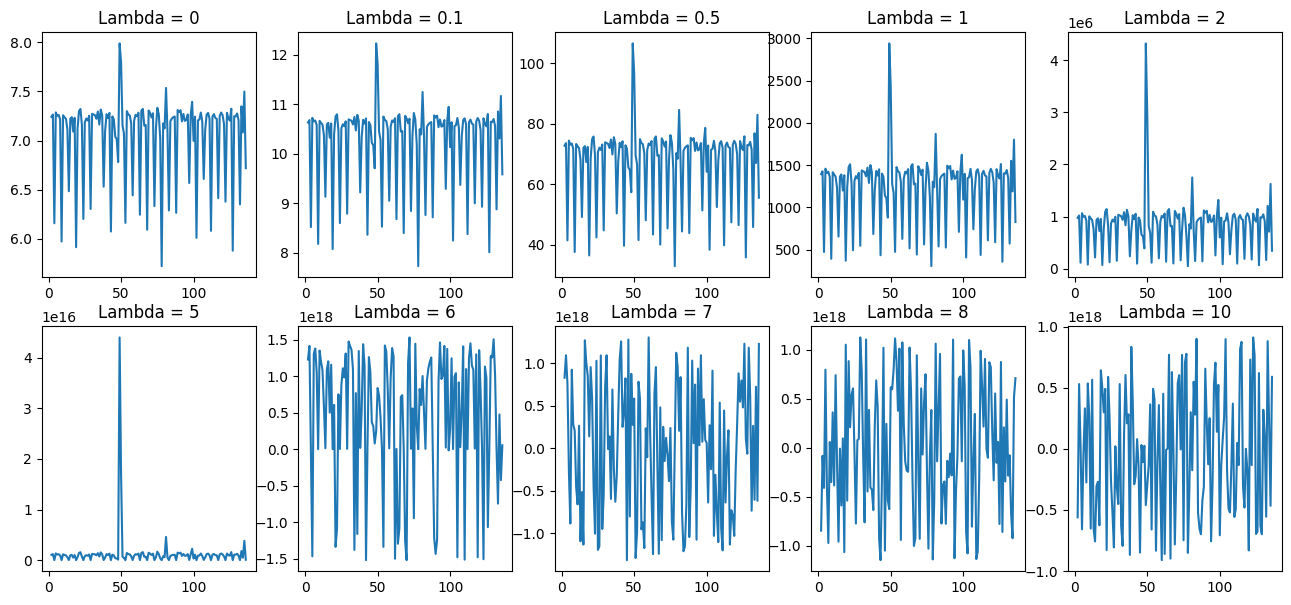

In [8]:
fig = plt.figure(figsize=(16,7))
axs = fig.subplots(2,5)

Liste_lambda = [0, 0.1, 0.5, 1, 2, 5, 6, 7, 8, 10]

for k, Lbda in enumerate(Liste_lambda):
    if Lbda == 0:                           # pour lambda = 0:   la transformation correspond à passer au log
        transf = np.log(Data_values)
    else: transf = (Data_values**Lbda-1)/Lbda
    transf.plot(ax = axs[k//5,k%5], title = f'Lambda = {Lbda}')

Les valeurs de Lambda entre 6 et 10 paraissent intéressantes, mais les valeurs sont proches de 10**18, trop proches des limites de précision de la machine. On choisit une transformation pour lambda = 0, c'est à dire qu'on applique le log :

In [9]:
Ldata = np.log(Data_values)
Ldata

2      7.240650
3      7.264030
4      6.159095
5      7.285507
6      7.250636
         ...   
132    6.350886
133    7.347300
134    7.082549
135    7.497207
136    6.719013
Name: nb_vues, Length: 135, dtype: float64

La PACF s'annulant pour h>=8, on peut essayer un modèle AR(7). Ce sera notre <span style='color:red'><b>modèle 1</b></span>.

### II - a) Modèles 2.X : élimination de la périodicité (pour la période 5)

On va éliminer la périodicité de 5 par une différentiation D=1, S=5, puis on vérifie la stationnarité :

ADF p-val :  1.4921886386810773e-12
KPSS p-val :  0.1


C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


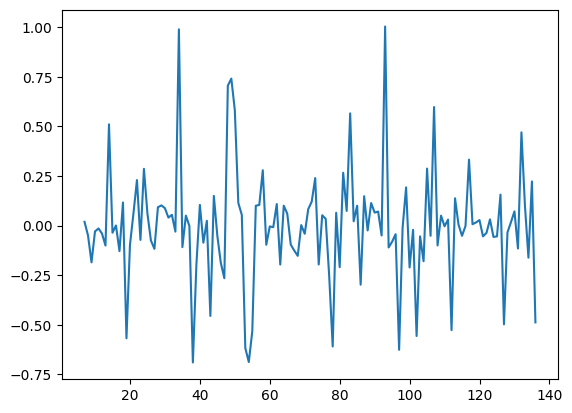

In [10]:
Ldata_Diff = Ldata.diff(5).dropna()
Ldata_Diff.plot()

# Testons la stationnarité après désaisonnalisation 
TestA = adfuller(Ldata_Diff) # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(Ldata_Diff) # Test KPSS :       H0 Stationnaire
print("KPSS p-val : ", TestK[1])


Le test de stationnarité est douteux, on essaiera tout de même une série de modèles <span style='color:red'><b>(modèles 2.X)</b></span> : SARIMA(p,<span style='color:red'><b>0</b></span>,q)(P,<span style='color:red'><b>1</b></span>,Q)_<span style='color:red'><b>5</b></span> :

On lance manuellement plusieurs tests '<b>sm.tsa.statespace.SARIMAX(Ldata, order=(p, 0, q), seasonal_order=(P, 1, Q, 5), trend=None)</b>', 
pour différentes valeurs de $p\leq4 , q\leq4 , P\leq6$ et $Q\leq6$, et nous regardons la significativité des coefficients obtenus.

Voici un exemple de calculs effectués :

In [11]:
Mod = sm.tsa.statespace.SARIMAX(Ldata, order=(3, 0, 3), seasonal_order=(2, 1, 2, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False)  # Tendance constante inutile car dérivation
# trend = None : pas de tendance linéaire (Inutile car dérivation d'ordre 2)

ModF = Mod.fit()
print(ModF.summary())


                                       SARIMAX Results                                        
Dep. Variable:                                nb_vues   No. Observations:                  135
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 5)   Log Likelihood                  -5.164
Date:                                Wed, 11 Jan 2023   AIC                             32.328
Time:                                        09:40:41   BIC                             62.617
Sample:                                             0   HQIC                            44.623
                                                - 135                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4263      0.294      1.450      0.147      -0.150       1.002
ar.

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


On essaye une série de modèles (modèles 2.X) : SARIMA(p,<span style='color:red'><b>0</b></span>,q)(P,<span style='color:red'><b>1</b></span>,Q)_<span style='color:red'><b>5</b></span>

Après plusieurs essais, nous retiendrons les modèles suivants :
- Modèle 2.1 : <BLOCKQUOTE> ARIMA(0,0,0)(3,1,0)[5] 
- Modèle 2.2 : <BLOCKQUOTE> ARIMA(3,0,4)(5,1,5)[5] 
- Modèle 2.2 : <BLOCKQUOTE> ARIMA(2,0,0)(3,1,3)[5] 
- Modèle 2.4 : <BLOCKQUOTE> ARIMA(3,0,0)(1,1,0)[5] 

 ### II - b) Modèles 3.X : elimination de la périodicité et différentiation

Après avoir éliminer la périodicité (D=1), on va tenter une différentiation d=1, puis on vérifie la stationnarité :

ADF p-val :  3.3042140277776134e-07
KPSS p-val :  0.1


C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


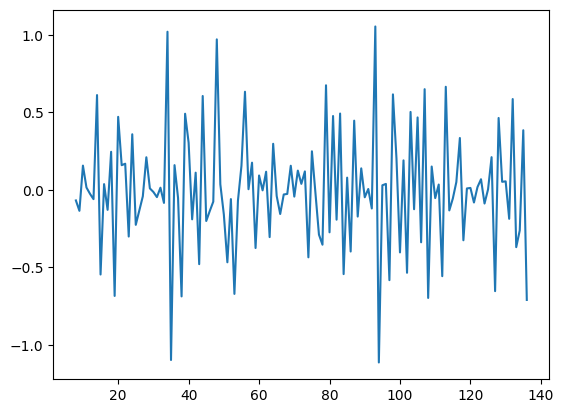

In [12]:
Ldata_dDiff = Ldata_Diff.diff(1).dropna()
Ldata_dDiff.plot()

# Testons la stationnarité après désaisonnalisation 
TestA = adfuller(Ldata_dDiff) # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(Ldata_dDiff) # Test KPSS :       H0 Stationnaire
print("KPSS p-val : ", TestK[1])

Le test de stationnarité est douteux, on essaiera tout de même une série de modèles (modèles 3.X) : SARIMA(p,<span style='color:red'><b>1</b></span>,q)(P,<span style='color:red'><b>1</b></span>,Q)_<span style='color:red'><b>5</b></span>


On a lance manuellement plusieurs tests '<b>sm.tsa.statespace.SARIMAX(Ldata, order=(p, 1, q), seasonal_order=(P, 1, Q, 5), trend=None)</b>', 
pour différentes valeurs de $p\leq4 , q\leq4 , P\leq6 et Q\leq6$, et nous regarderons la significativité des coefficients obtenus.

Voici un exemple de calculs effectués :

In [15]:
Mod = sm.tsa.statespace.SARIMAX(Ldata, order=(4, 1, 4), seasonal_order=(5, 1, 5, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False)  # Tendance constante inutile car dérivation
# trend = None : pas de tendance linéaire (Inutile car dérivation d'ordre 2)

ModF = Mod.fit()
print(ModF.summary())

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                            
Dep. Variable:                                         nb_vues   No. Observations:                  135
Model:             SARIMAX(4, 1, 4)x(5, 1, [1, 2, 3, 4, 5], 5)   Log Likelihood                  -1.898
Date:                                         Wed, 11 Jan 2023   AIC                             41.795
Time:                                                 09:59:30   BIC                             91.102
Sample:                                                      0   HQIC                            61.745
                                                         - 135                                         
Covariance Type:                                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1     

Après plusieurs essais, nous retiendrons les modèles suivants :
- Modèle 3.1 : <BLOCKQUOTE> ARIMA(3,1,0)(0,1,0)[5] 
- Modèle 3.2 : <BLOCKQUOTE> ARIMA(4,1,0)(5,1,0)[5] 
- Modèle 3.2 : <BLOCKQUOTE> ARIMA(0,1,0)(1,1,0)[5] 
- Modèle 3.4 : <BLOCKQUOTE> ARIMA(0,1,0)(2,1,0)[5]
- Modèle 3.5 : <BLOCKQUOTE> ARIMA(1,1,0)(1,1,1)[5] 

### II - c) Modèles 4.X : Modèles proposé par AutoArima (package pmdarima.arima)

In [13]:
from pmdarima.arima import auto_arima

In [14]:
model = auto_arima(Ldata,
                      test='adf',   

                      # paramètres liés à la modélisation ARIMA : p, d, q
                      start_p=0, 
                      start_q=0,
                      max_p=8, max_q=8,
                      d=0,          
                      
                      seasonal=True,    # prendre en compte la saisonnalité
                      m=5,              # période de saisonnalité


                      # paramètres liés à la saisonnalité : P, D, Q
                      start_P=0, start_Q=0,
                      max_P=8, max_Q=8,
                      D=0, 
                      
                      max_order =10,                    # somme maximale des paramètres p, q, P, Q
                      n_jobs = 5,                       # Division du travail

                      information_criterion='bic',      # Critère de choix du 'meilleur modèle'

                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[5] intercept   : BIC=155.259, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : BIC=101.369, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[5]             : BIC=915.994, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : BIC=148.993, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : BIC=inf, Time=0.79 sec
 ARIMA(0,0,1)(0,0,2)[5] intercept   : BIC=79.967, Time=0.13 sec
 ARIMA(0,0,1)(1,0,2)[5] intercept   : BIC=109.825, Time=0.69 sec
 ARIMA(0,0,1)(0,0,3)[5] intercept   : BIC=69.072, Time=0.32 sec
 ARIMA(0,0,1)(1,0,3)[5] intercept   : BIC=inf, Time=0.87 sec
 ARIMA(0,0,1)(0,0,4)[5] intercept   : BIC=66.736, Time=0.39 sec
 ARIMA(0,0,1)(1,0,4)[5] intercept   : BIC=inf, Time=1.41 sec
 ARIMA(0,0,1)(0,0,5)[5] intercept   : BIC=62.357, Time=0.63 sec
 ARIMA(0,0,1)(1,0,5)[5] intercept   : BIC=62.053, Time=1.90 sec
 ARIMA(0,0,1)(2,0,5)[5] intercept   : BIC=inf, Time=1.76 sec
 ARIMA(

La fonction <b>auto_arima</b> 'par défaut' nous propose des valeurs de différentiation d = D = 0, en contradiction avec nos observations.

Nous allons tester les modèles proposés, puis relancer <b>auto_arima</b> en forçant les différentiations d = 1 ou D = 1,

Voici les différentes modélisations proposées obtenus avec les critères 'AIC' ou 'BIC' :


- Modèle 4.1 : BIC, d = D = 1 : <BLOCKQUOTE> ARIMA(2,1,0)(1,1,0)[5] 


- Modèle 4.2 : BIC d=0, D=1 :    <BLOCKQUOTE>ARIMA(0,0,0)(1,1,0)[5]


- Modèle 4.3 : BIC d=D=0   (cas renvoyé par les réglages par défaut) <BLOCKQUOTE>ARIMA(0,0,0)(0,0,5)[5]


- Modèle 4.4 : BIC d=1, D=0  <BLOCKQUOTE>ARIMA(1,1,0)(1,0,0)[5]


- AIC, D=1 ARIMA(0,0,0)(1,1,0)[5] : même modèle que 4.2




###  III - Choix du "meilleur" modèle
Nous allons départager nos différents modèles en fonction de leur capacités de prédictions.

Voici un rappel des 14 modèles SARIMA à tester :
<table border=0 cellpadding=0 cellspacing=0 width=432 >

 <tr height=19>
  <td height=19></td>
  <td>Modèles</td>
  <td>p</td>
  <td>d</td>
  <td>q</td>
  <td>P</td>
  <td>D</td>
  <td>Q</td>
  <td>S</td>
 </tr>
 <tr height=5>
  <td height=5></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=19>
  <td height=19>AR(7)</td>
  <td>1</td>
  <td>7</td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=5>
  <td height=5></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=19>
  <td height=19>d=0<span
  style='mso-spacerun:yes'>   </span>D=1</td>
  <td>2.1</td>
  <td>0</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>3</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>2.2</td>
  <td>3</td>
  <td class=xl6727579>0</td>
  <td>4</td>
  <td>5</td>
  <td class=xl6827579>1</td>
  <td>5</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>2.3</td>
  <td>2</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>3</td>
  <td class=xl6827579>1</td>
  <td>3</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>2.4</td>
  <td>3</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=5>
  <td height=5></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=19>
  <td height=19>d=1<span
  style='mso-spacerun:yes'>   </span>D=1</td>
  <td>3.1</td>
  <td>3</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>0</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>3.2</td>
  <td>4</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>3.3</td>
  <td>0</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>3.4</td>
  <td>0</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>2</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>3.5</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>1</td>
  <td>5</td>
 </tr>
 <tr height=5>
  <td height=5></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=19>
  <td height=19>AutoArima</td>
  <td>4.1</td>
  <td>2</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>4.2</td>
  <td>0</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>4.3</td>
  <td>0</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>0</td>
  <td class=xl6727579>0</td>
  <td>5</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>4.4</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>5</td>
 </tr>

</table>


In [16]:
n_p_t = 3                               # Nb de périodes tronquées
Ldata_tronque = Ldata[:-5*n_p_t]

In [20]:

liste_model = {}

# Un premier modèle :
liste_model['Mod11'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(7, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)

# Modèles de type (d, D) = (0, 1)
liste_model['Mod21'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 0, 0), seasonal_order=(3, 1, 3, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod22'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(3, 0, 4), seasonal_order=(5, 1, 5, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod23'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(2, 0, 0), seasonal_order=(3, 1, 3, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod24'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(3, 0, 0), seasonal_order=(1, 1, 1, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)

# Modèles de type (d, D) = (1, 1)
liste_model['Mod31'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(3, 1, 0), seasonal_order=(0, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod32'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(4, 1, 0), seasonal_order=(5, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod33'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 1, 0), seasonal_order=(1, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod34'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 1, 0), seasonal_order=(2, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod35'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(1, 1, 0), seasonal_order=(1, 1, 1, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)

# Autres modèles proposés par AutoArima
liste_model['Mod41'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(2, 1, 2), seasonal_order=(1, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod42'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 0, 2), seasonal_order=(1, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod43'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 0, 2), seasonal_order=(0, 0, 5, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)
liste_model['Mod44'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(1, 1, 2), seasonal_order=(1, 0, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit(disp=0)


                                     SARIMAX Results                                     
Dep. Variable:                           nb_vues   No. Observations:                  120
Model:             SARIMAX(4, 1, 0)x(5, 1, 0, 5)   Log Likelihood                 -11.539
Date:                           Wed, 11 Jan 2023   AIC                             43.078
Time:                                   10:13:35   BIC                             67.504
Sample:                                        0   HQIC                            52.903
                                           - 120                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8112      0.105     -7.695      0.000      -1.018      -0.605
ar.L2         -0.7015      0.135     -5.200

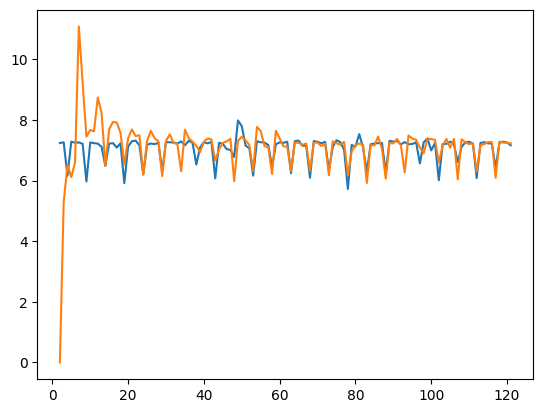

In [21]:
# Voici un résumé obtenu pour l'un des modèles (3.2)
print(liste_model['Mod32'].summary())
Fig = Ldata_tronque.plot()
liste_model['Mod32'].fittedvalues.plot(ax = Fig)
Fig.figure
plt.show()

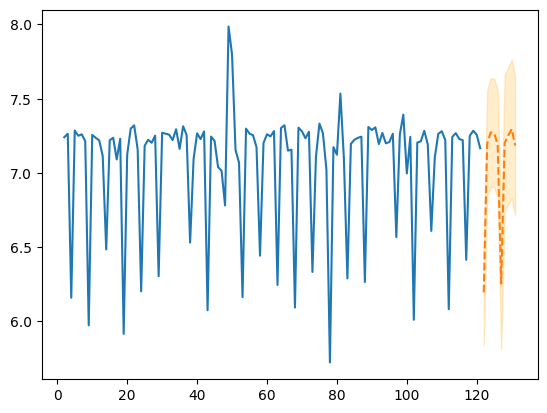

In [26]:
# Prédiction du modèle 3.2 sur les 3 dernières semaines :

Pred = liste_model['Mod32'].get_forecast(steps=10).summary_frame(alpha=0.2)
Fig = Ldata_tronque.plot()
Pred['mean'].plot(ax=Fig, style='--')
Fig.fill_between(Pred.index, Pred['mean_ci_lower'], Pred['mean_ci_upper'], color='orange', alpha=0.2)
Fig.figure
plt.show()


Test des prédictions pour les 14 modèles :

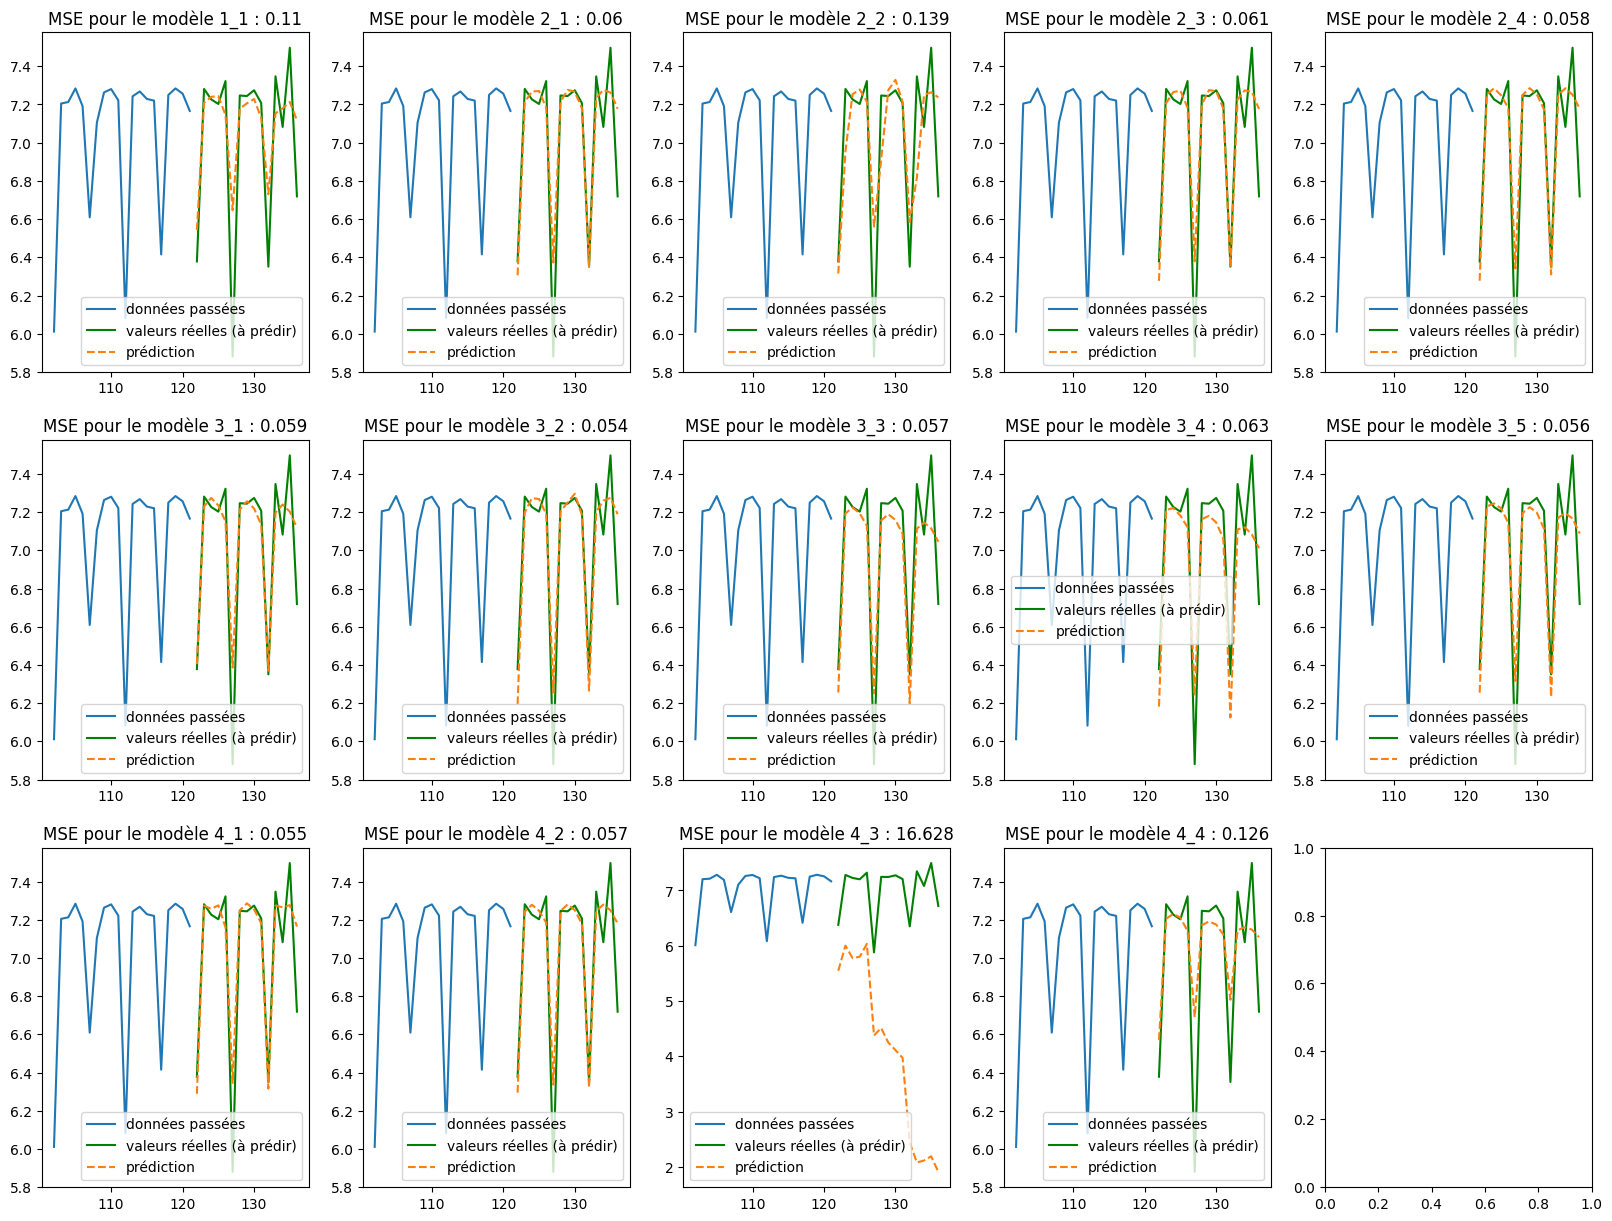

In [27]:
fig = plt.figure(figsize=(20,15))
axs = fig.subplots(3,5)

for k, mod in enumerate(liste_model):       # Parcours des 14 Modèles
    
    # Modèle concerné
    modele = liste_model[mod]

    # Fenêtre d'affichage
    fenetre = axs[k//5, k%5]

    # Prédiction à n_p_t périodes
    Pred = modele.get_forecast(steps=5*n_p_t).summary_frame(alpha=0.01)
    
    # MSE
    MSE = sum((Pred['mean']-Ldata[-5*n_p_t:])**2)/10  

    # Affichage des quelques valeurs précédentes
    Ldata_tronque[-20:].plot(ax=fenetre,  label='données passées')

    # Affichage des valeurs réelles en vert
    Ldata[-5*n_p_t:].plot(color='green', ax=fenetre,  label='valeurs réelles (à prédir)')

    # Affichage des prédictions en pointillé
    Pred['mean'].plot(ax=fenetre, style='--', label='prédiction')

    # Affichage du titre avec MSE arrondi au millième :
    fenetre.set_title(f'MSE pour le modèle {mod[3:4]}_{mod[4:]} : {round(MSE,3)}')
    fenetre.legend()    

plt.show()



Au regard de la MSE, plusieurs modèles sont plus intéressants : 3.2, 4.1 4.5. Nous choississons par la suite le modèle 3_2 en tant que 'meilleur' modèle.

In [60]:
# On extrait le meilleur modèle
meilleur_model = liste_model['Mod32']

### IV - Analyse de notre "meilleur" modèle



On ré-entraine le modèle sur les données complètes (non tronquées) :

In [61]:
meilleur_model_c = sm.tsa.statespace.SARIMAX(Ldata, order=(4, 1, 0), seasonal_order=(5, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()

In [62]:
print(meilleur_model_c.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           nb_vues   No. Observations:                  135
Model:             SARIMAX(4, 1, 0)x(5, 1, 0, 5)   Log Likelihood                 -11.024
Date:                           Wed, 11 Jan 2023   AIC                             42.047
Time:                                   10:48:16   BIC                             68.099
Sample:                                        0   HQIC                            52.591
                                           - 135                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8544      0.080    -10.620      0.000      -1.012      -0.697
ar.L2         -0.7378      0.103     -7.136

<b><u>Remarque :</u></b> On obtient des résultats assez aberrants concernant les différentes p-value. En contradiction avec nos résultats précédents (prévisions depuis les données tronquées).

Superposons les données et la valeurs prédites par le modèle :

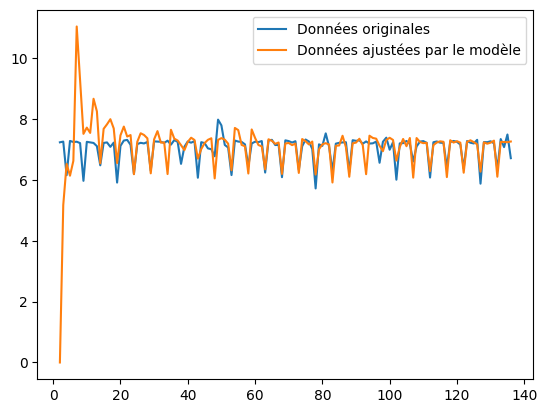

In [63]:
Ldata.plot(label = 'Données originales')
meilleur_model_c.fittedvalues.plot(label = 'Données ajustées par le modèle')
plt.legend()

Concernant les résidus : Si notre modèle est correct, alors les résidus forment un bruit blanc. Analysons les résidus du modèle :

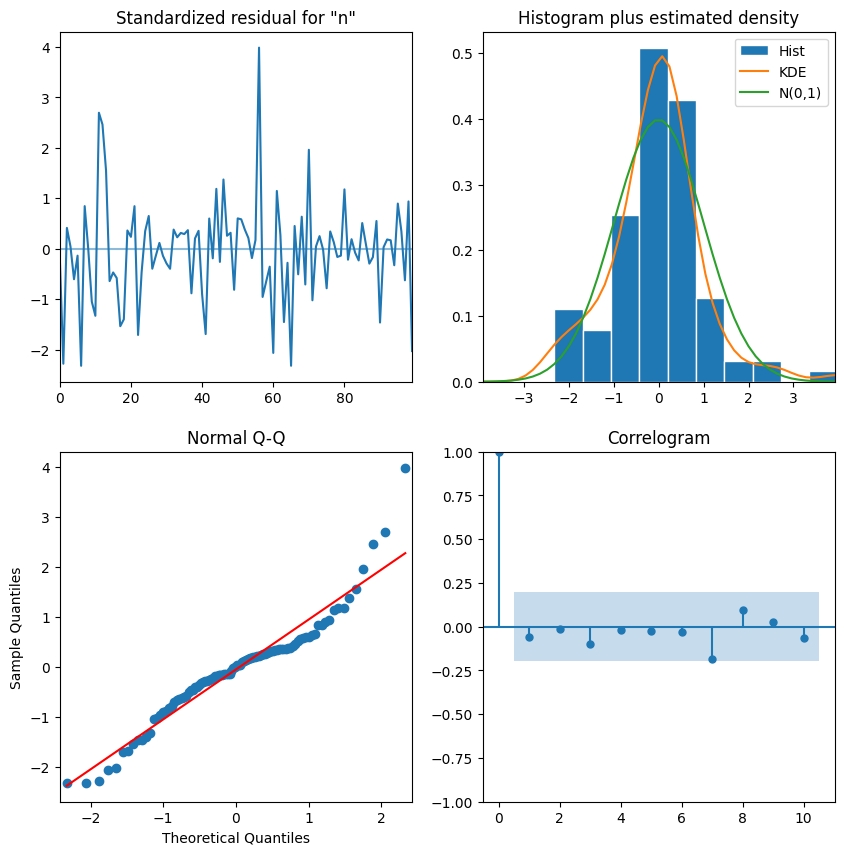

In [64]:
# Normalité des résidus
meilleur_model_c.plot_diagnostics(figsize = (10,10)).show()


On remarque :
- Les résidus standardisés sont majoritairement situés dans l'intervalle [-1.96, 1.96],
- La distribution des résidus semblent être normalement distribués avec une moyenne de zéro. Cela peut indiquer un ajustement correct du modèle,
- La QQ-plot compare les quantiles des erreurs de résidus avec ceux d'une distribution normale. Les points sont approximativement alignés sur la ligne diagonale, cela indique que les résidus sont approximativement normalement distribués. Certains points du graphique sont légèrement éloignés de la ligne diagonale, mais pas suffisamment pour être considérée comme significativement différente d'une distribution normale,
- Le corrélogramme montre l'autocorrélation des résidus à différentes valeurs décalage (retard). L'autocorrélation $ \rho (h) $ est significativement nulle, ce qui indique qu'il ne reste presque'aucune information à extraire.

In [66]:
# Normalité des résidus : test de Shapiro
from scipy.stats import shapiro

# H0 : Normal distribution
shapiro(meilleur_model_c.resid) 


ShapiroResult(statistic=0.5378026962280273, pvalue=8.096148118600047e-19)

Le test de Shapiro rejète la normalité des résidus, ce qui contredit nos résultats précédents.

Concernant la stationarité des résidus :

In [67]:
# Test ADF :    H0 Non Stationnaire
TestA = adfuller(meilleur_model_c.resid) 
print("ADF p-val : ", TestA[1])

# Test KPSS :       H0 Stationnaire
TestK = kpss(meilleur_model_c.resid) 
print("KPSS p-val : ", TestK[1])

ADF p-val :  5.671085380391042e-05
KPSS p-val :  0.1


C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Les tests ADF et KPSS indique une stationarité des résidus.

In [73]:
# Test de bruit blanc
sm.stats.acorr_ljungbox(meilleur_model_c.resid, lags=20, boxpierce = True)   # H0 : Pas d'autocorrélation des résidus

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,11.219604,0.000809,10.973919,0.000924
2,11.471773,0.003228,11.218726,0.003663
3,14.617694,0.002174,14.249832,0.002584
4,14.788903,0.005160,14.413543,0.006086
5,22.013577,0.000520,21.269073,0.000721
6,24.399463,0.000441,23.515637,0.000641
7,26.632856,0.000388,25.602311,0.000593
8,26.694569,0.000798,25.659519,0.001201
9,26.697046,0.001570,25.661797,0.002320
10,27.576210,0.002110,26.463954,0.003164


Les différents résultats des tests de Ljung-Box et de Box-Pierce montrent qu'on ne rejète pas l'autocorrélation des résidus, et qu'il ne s'agit pas à priori d'un bruit blanc. Ce qui n'est pas en cohérence avec nos résultats précédents.

### V - Prédiction avec notre "meilleur" modèle



Pour finir, nous allons revenir à nos données non transformées (avant le passage au log), en appliquant la fonction du cours (p47).

puis, même si notre modèle n'est pas parfait, nous tenterons de faire des prévisions sur les semaines suivantes.


In [79]:
# Choix du nb de semaines à prédir
nb_semaines = 10

# Obtention des prévisions
Lprevision = meilleur_model_c.get_forecast(steps=nb_semaines).summary_frame(alpha=0.2)
sigma2_chapeau_mm = 0.0730
prevision = np.exp(Lprevision + sigma2_chapeau_mm/2)

# Concernant l'intervale de confiance au niveau 1% :
log_low_prev = Lprevision.mean_ci_lower
log_high_prev = Lprevision.mean_ci_upper

low_prev = np.exp(log_low_prev)
high_prev = np.exp(log_high_prev)


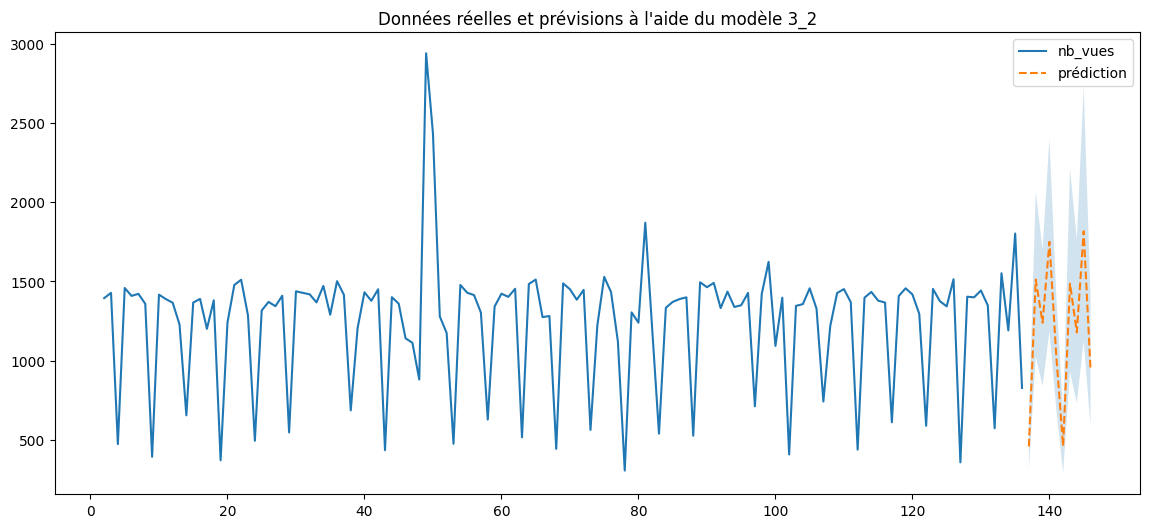

In [87]:

# Affichage des quelques valeurs précédentes
Data.plot(label='données Youtube')

# affichage de la zone de confiance
date_max = Data.index[-1]
plt.fill_between(range(date_max+1,date_max+1+nb_semaines), low_prev, high_prev, alpha = 0.2)

# Affichage des prédictions en pointillé
prevision['mean'].plot(style='--', label='prédiction', figsize=(14, 6))

# Affichage du titre avec MSE arrondi au millième :
plt.title(f"Données réelles et prévisions à l'aide du modèle 3_2")
plt.legend()    

plt.show()

# V - Conclusion

Même si au vu de certains indicateurs (notamment lors de l'étude des résidus), les modèles SARIMA ne semblent pas complètement adaptés à nos données. Quelques modèles semblent plutôt bien prédir les données, notamment le modèle 3.2 : SARIMA(p,d,q)(P,D,Q)_S = (4, 1, 0)(5, 1, 0)_5.

<br>

##### <u><i>Epilogue</i></u> :

A titre d'information : voici les nouvelles données que nous avons récupérées le 02/01/2023 et qui nous permettent de comparer (visuellement) nos prédictions avec les nouvelles observations :

<center><img src='new_data.png'></center>

On constate que nos prévisions étaient plutôt correctes !


<br>

<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>



<br>

                                                                                                                            .

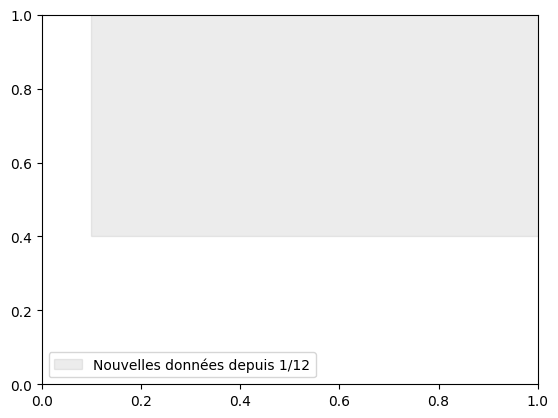

In [104]:
from matplotlib.patches import Rectangle

fig = plt.figure()
ax = fig.add_subplot()

xy=(0.1,0.4)
w=4
h=2

rect = Rectangle(xy, w, h, color="gray", alpha = 0.15, label='Nouvelles données depuis 1/12')

ax.add_patch(rect)

ax.legend()